In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
gpu = True

In [ ]:
root_folder = 'FC_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [ ]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [ ]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn([1, 2])
fixed_data, _ = next(iter(test_loader))
x = np.linspace(-3, 3, 10)
y = np.linspace(-3, 3, 10)
X,Y = np.meshgrid(x,y)
XY=np.array([X.flatten(),Y.flatten()]).T
xy = torch.tensor(XY)
# xy = np.mgrid[-3:3.1:1, -3:3.1:1].reshape(2,-1).T
if gpu:
    fixed_z = fixed_z.to(device)
    fixed_data = fixed_data.to(device)
    xy = xy.to(device)

In [ ]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh, flatten=False):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        print(self.latent_size)
        self.gamma = gamma

        self.fce = FullyConnected([784, 512, 128, latent_size*2], activation_fn=nn.ReLU, flatten=True)
        self.fcd = FullyConnected([latent_size, 128, 512, 784], activation_fn=nn.ReLU)
        
        self._loss = None
        if gpu:
            self.to(device)
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
    
    def encode(self, x):
        h = self.fce(x)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = torch.tanh(self.fcd(h))
        x = flatten.view(-1, 1, 28, 28)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            randnorm = self._sample(mu.shape[0])
            if gpu:
                randnorm = randnorm.to(device)
            h = randnorm * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [ ]:
models = {'VAE10': Net(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

2


In [ ]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        if gpu:
            data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [ ]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            if gpu:
                data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        fixed_gen = []
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.cpu().numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            result = []
            for fixed in xy:                 
                fixed_gen =  models[k].decode(fixed.float()).data.cpu().numpy()
                result.extend(fixed_gen)            
            fixed_gen = torch.Tensor(result)
            print(fixed_gen.shape)
            plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.9336
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.2414
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.2180
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.2057
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.2257
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.2171


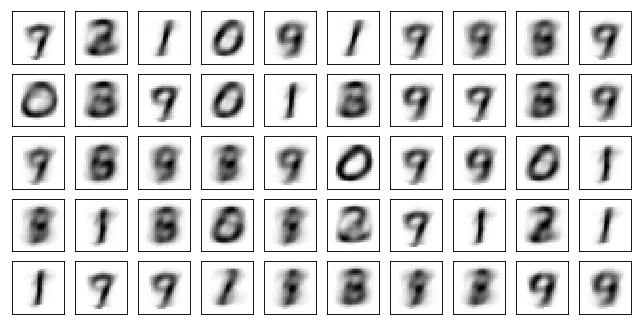

torch.Size([100, 1, 28, 28])


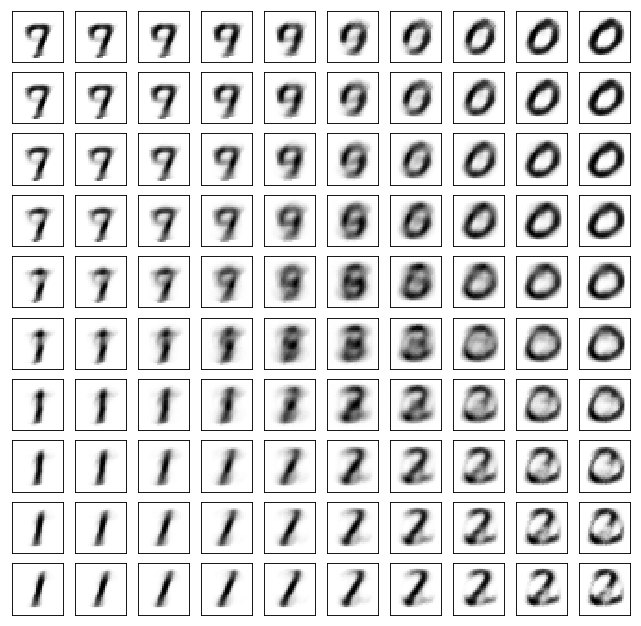

Test losses: VAE10: 0.2082/2.7413
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.2115
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.1905
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.2116
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.2163
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.1814
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.2218


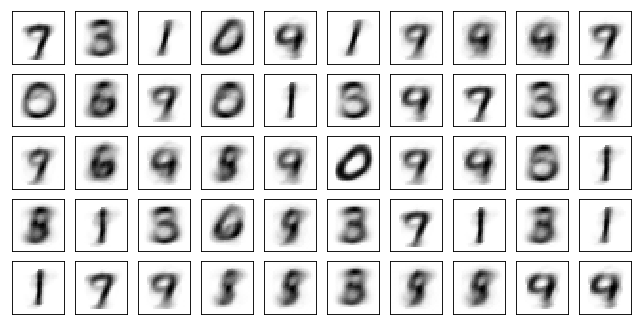

torch.Size([100, 1, 28, 28])


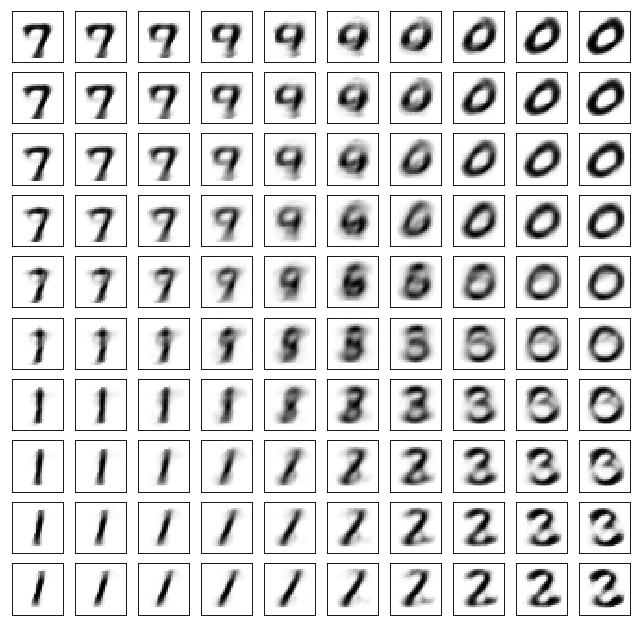

Test losses: VAE10: 0.1957/3.1365
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.2092
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.2021
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.2016
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.2061
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1915
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1964


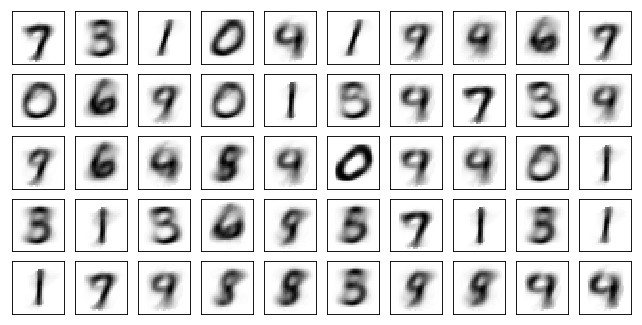

torch.Size([100, 1, 28, 28])


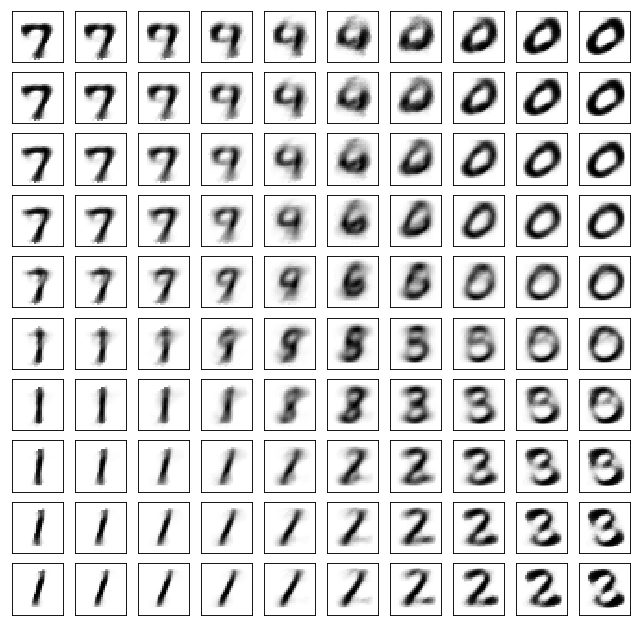

Test losses: VAE10: 0.1873/3.7099
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.1985
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1863
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1912
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.1922
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1813
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1698


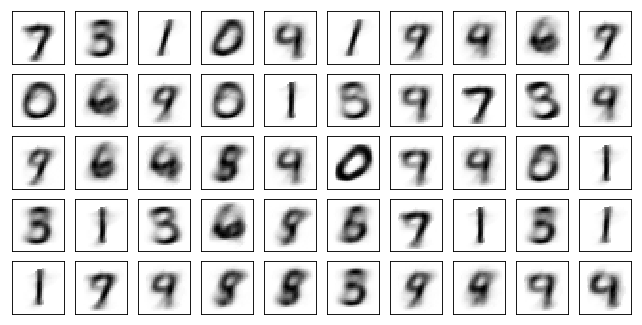

torch.Size([100, 1, 28, 28])


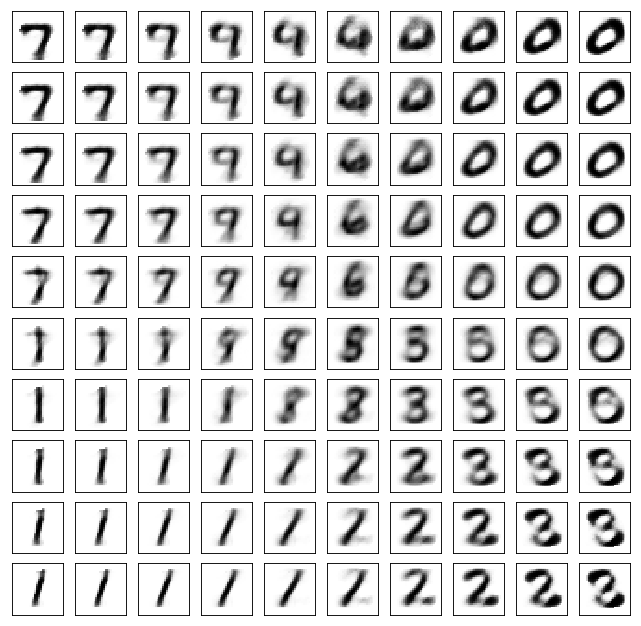

Test losses: VAE10: 0.1830/3.5567
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.2044
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1811
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1831
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1824
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1880
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1927


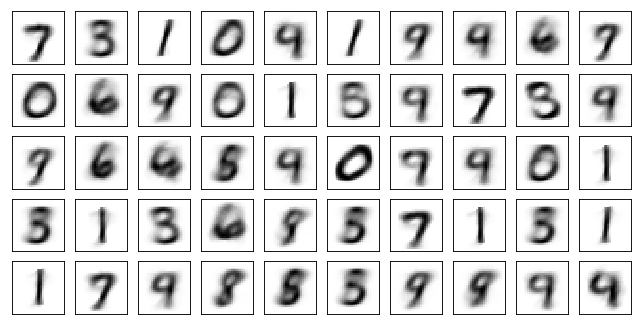

torch.Size([100, 1, 28, 28])


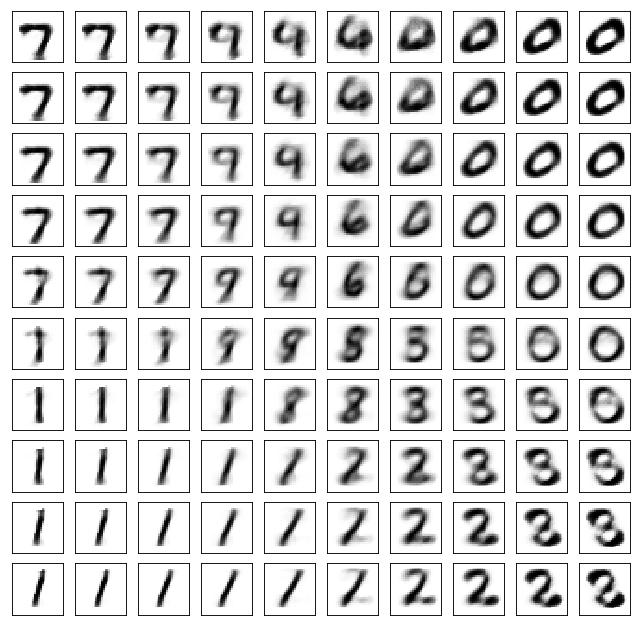

Test losses: VAE10: 0.1792/3.8412
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1916
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1928
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1679
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1888
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1776
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1695


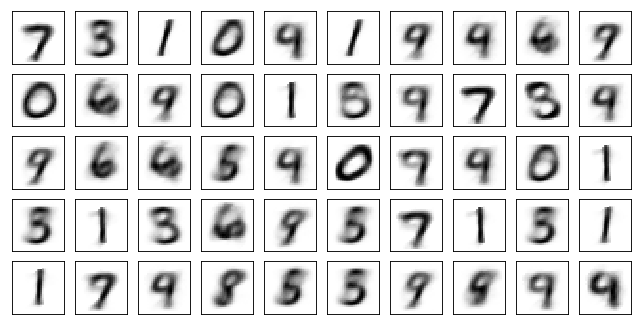

torch.Size([100, 1, 28, 28])


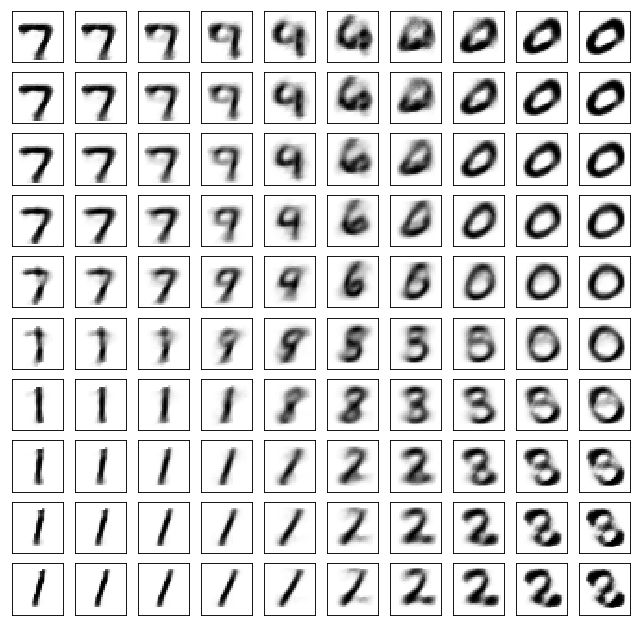

Test losses: VAE10: 0.1761/3.9803
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1795
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1813
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.1675
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1751
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1781
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1610


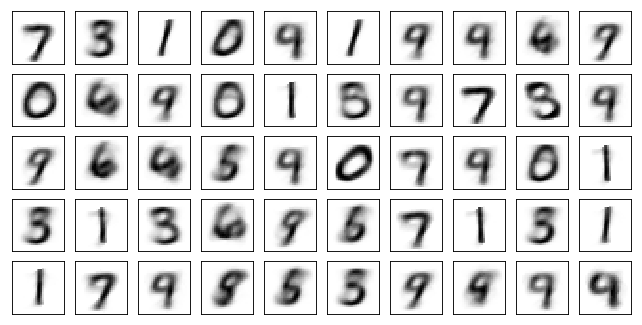

torch.Size([100, 1, 28, 28])


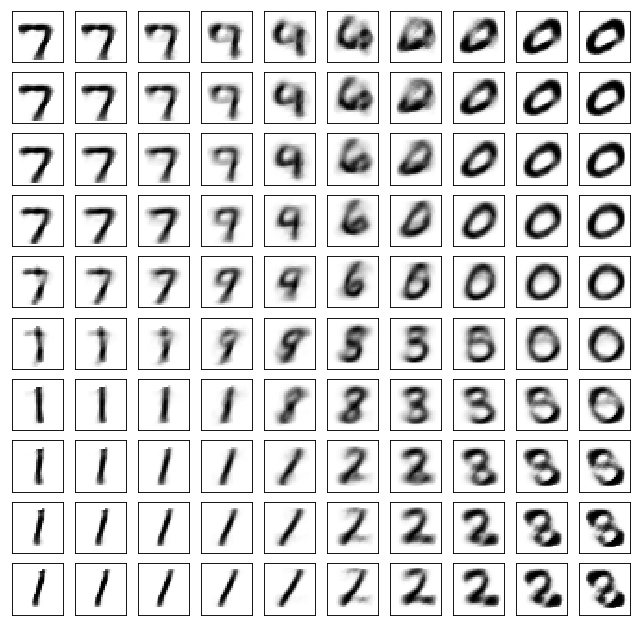

Test losses: VAE10: 0.1735/4.0896
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1773
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1840
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1863
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1585
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1866
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.1681


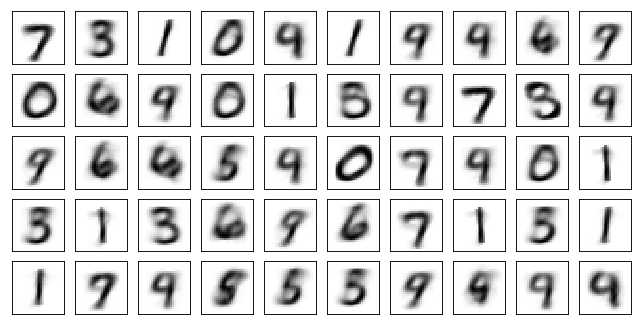

torch.Size([100, 1, 28, 28])


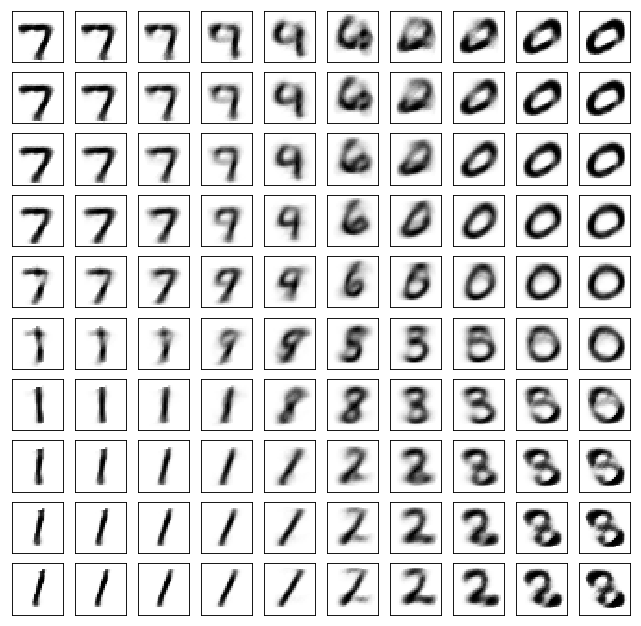

Test losses: VAE10: 0.1716/4.1548
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1906
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1544
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1596
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1649
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1555
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1903


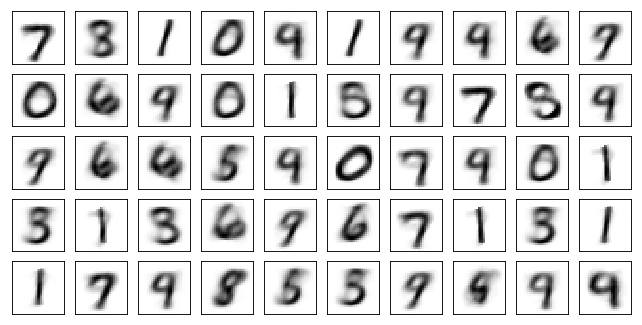

torch.Size([100, 1, 28, 28])


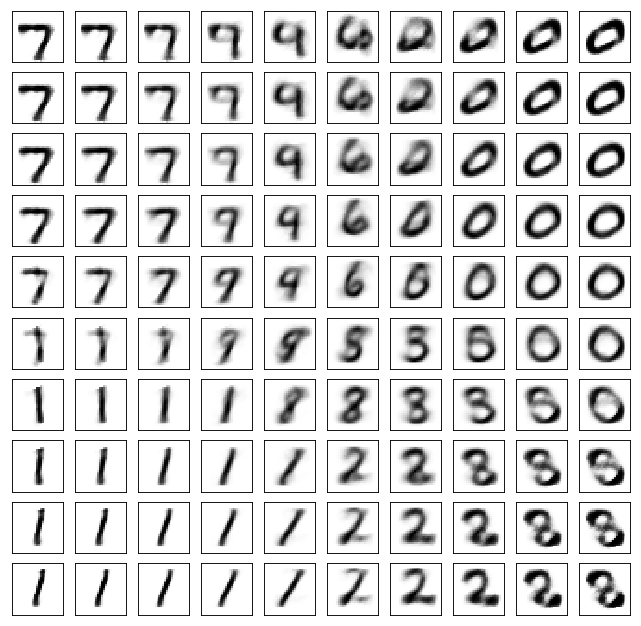

Test losses: VAE10: 0.1695/4.2088
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1678
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1701
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1869
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1884
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.1944
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1628


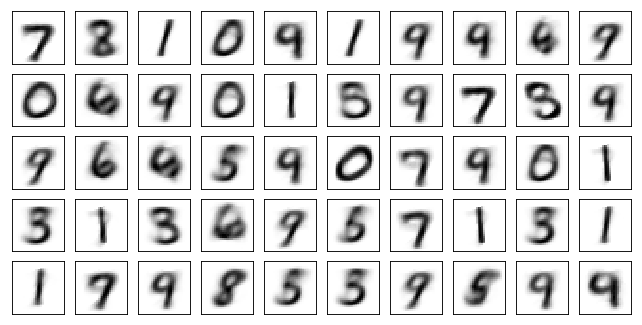

torch.Size([100, 1, 28, 28])


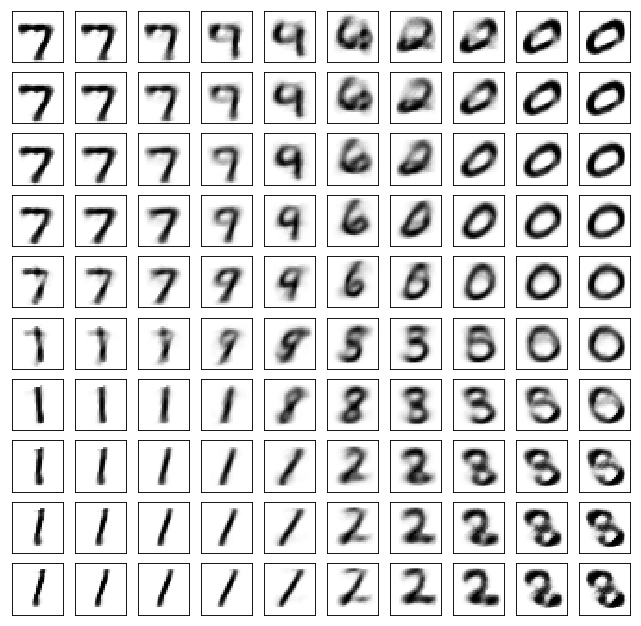

Test losses: VAE10: 0.1678/4.3862
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1905
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE10: 0.1644
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE10: 0.1673
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE10: 0.1530
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE10: 0.1651
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE10: 0.1796


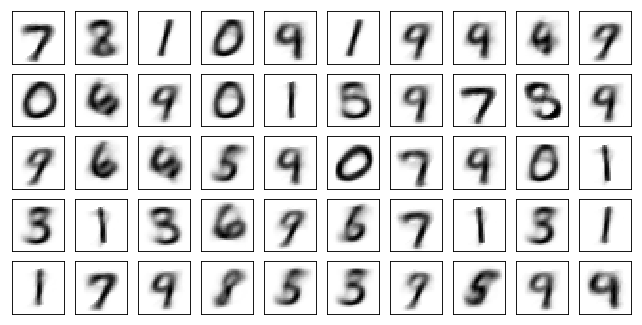

torch.Size([100, 1, 28, 28])


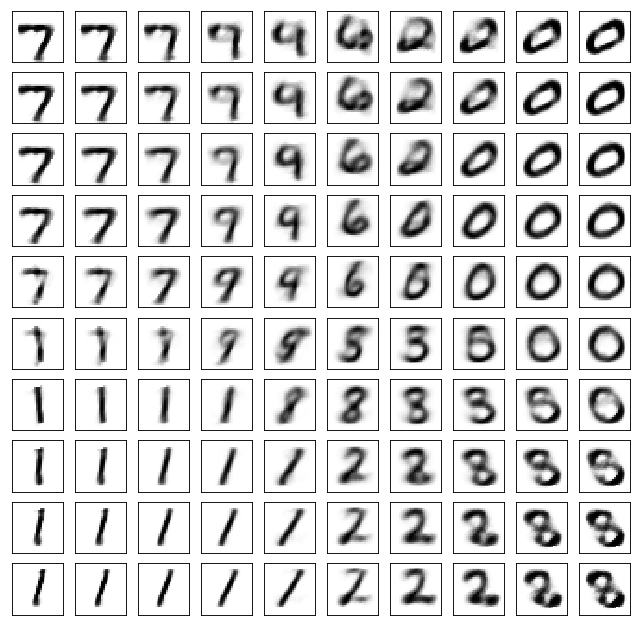

Test losses: VAE10: 0.1666/4.3895
Train Epoch: 12 [0/50000 (0%)]	Losses VAE10: 0.1775
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE10: 0.1561
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE10: 0.1671
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE10: 0.1661
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE10: 0.1756
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE10: 0.1697


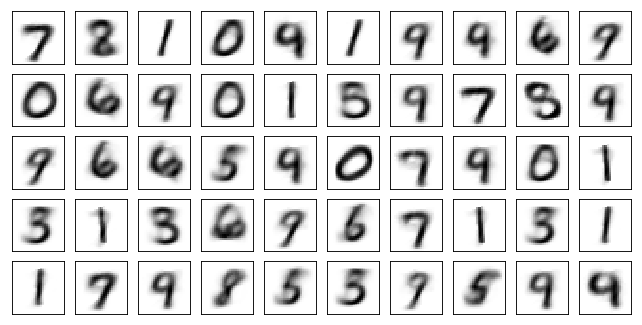

torch.Size([100, 1, 28, 28])


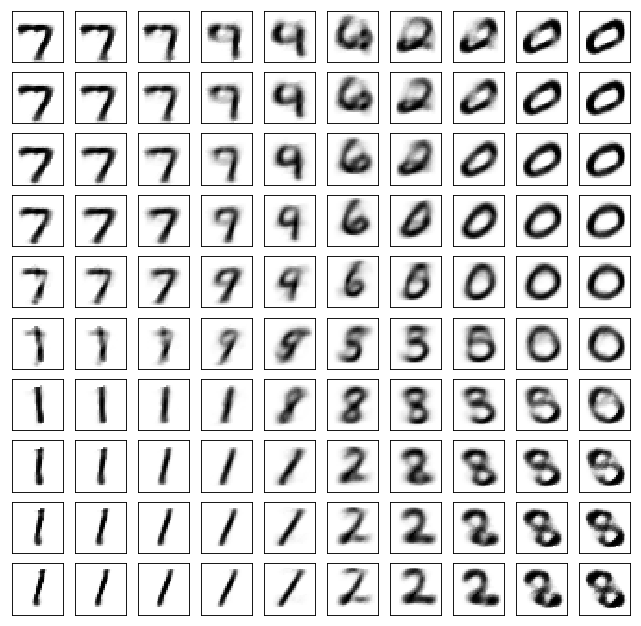

Test losses: VAE10: 0.1655/4.3695
Train Epoch: 13 [0/50000 (0%)]	Losses VAE10: 0.1655
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE10: 0.1888
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE10: 0.1825
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE10: 0.1815
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE10: 0.1646
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE10: 0.1713


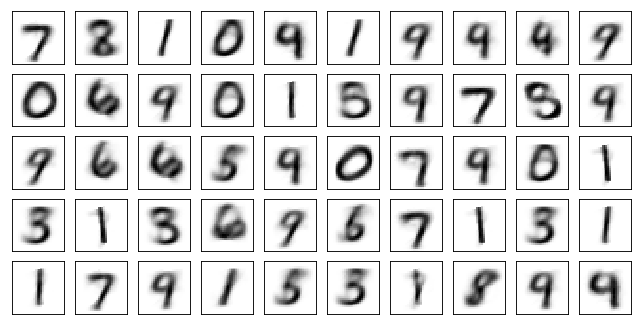

torch.Size([100, 1, 28, 28])


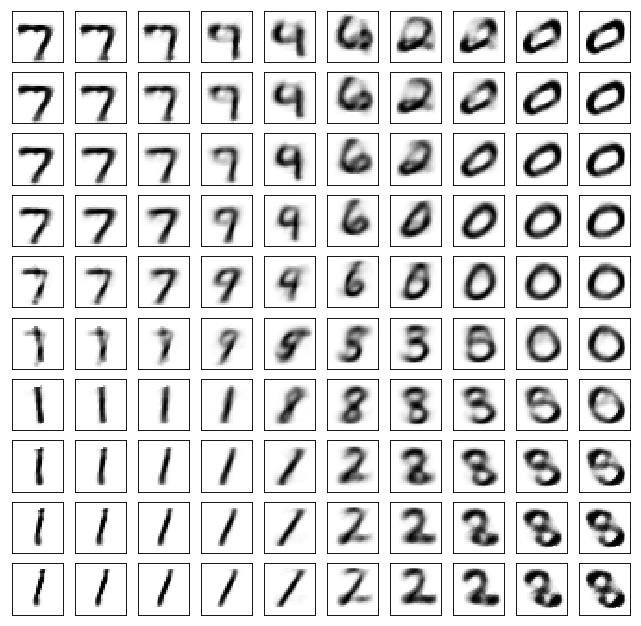

Test losses: VAE10: 0.1644/4.4184
Train Epoch: 14 [0/50000 (0%)]	Losses VAE10: 0.1817
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE10: 0.1703
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE10: 0.1666
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE10: 0.1655
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE10: 0.1621
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE10: 0.1682


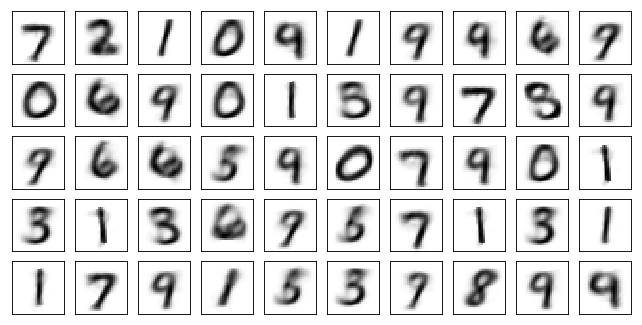

torch.Size([100, 1, 28, 28])


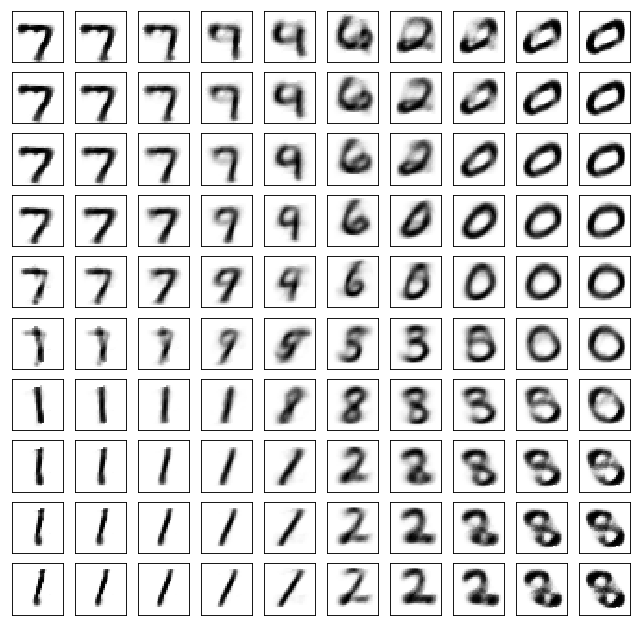

Test losses: VAE10: 0.1631/4.5124
Train Epoch: 15 [0/50000 (0%)]	Losses VAE10: 0.1704
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE10: 0.1511
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE10: 0.1614
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE10: 0.1756
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE10: 0.1829
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE10: 0.1649


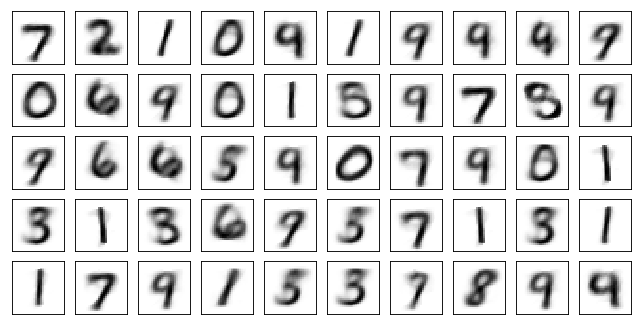

torch.Size([100, 1, 28, 28])


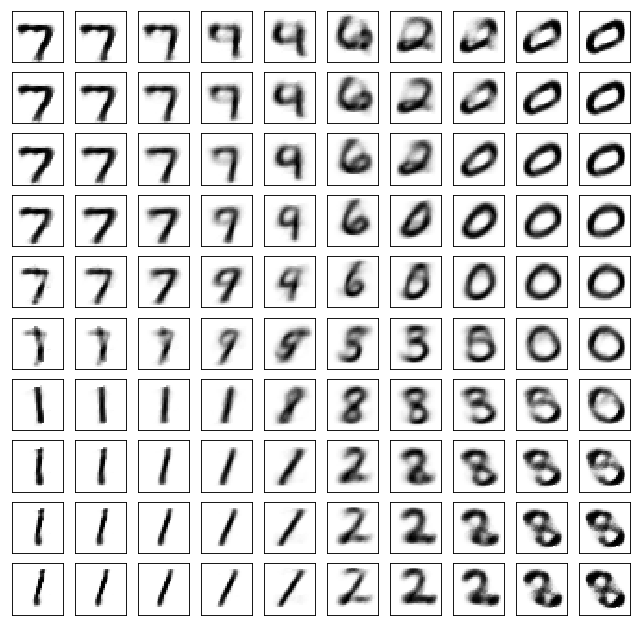

Test losses: VAE10: 0.1624/4.4610
Train Epoch: 16 [0/50000 (0%)]	Losses VAE10: 0.1685
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE10: 0.1679
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE10: 0.1600
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE10: 0.1721
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE10: 0.1604
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE10: 0.1833


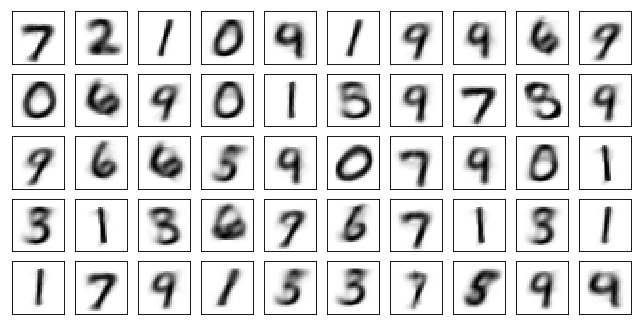

torch.Size([100, 1, 28, 28])


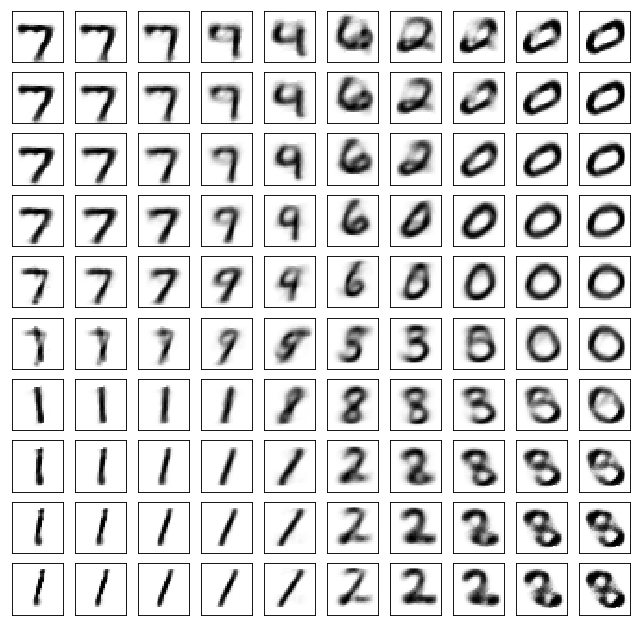

Test losses: VAE10: 0.1615/4.5333
Train Epoch: 17 [0/50000 (0%)]	Losses VAE10: 0.1782
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE10: 0.1552
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE10: 0.1830
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE10: 0.1733
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE10: 0.1662
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE10: 0.1719


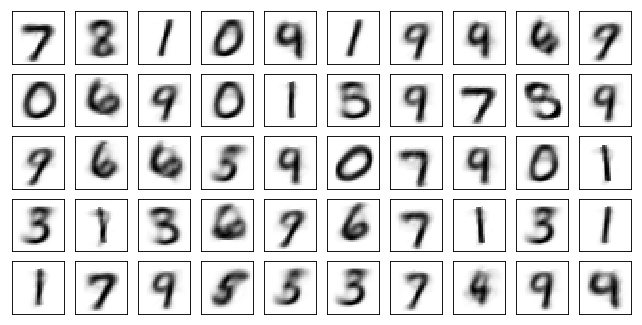

torch.Size([100, 1, 28, 28])


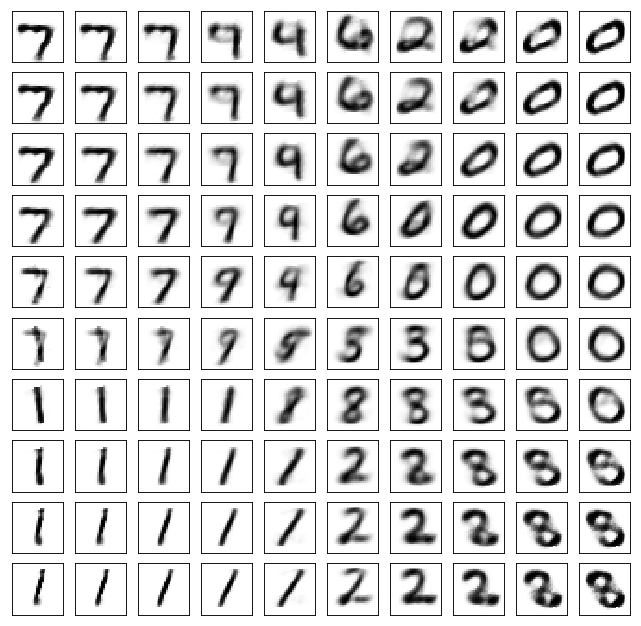

Test losses: VAE10: 0.1610/4.5577
Train Epoch: 18 [0/50000 (0%)]	Losses VAE10: 0.1532
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE10: 0.1592
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE10: 0.1486
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE10: 0.1550
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE10: 0.1761
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE10: 0.1769


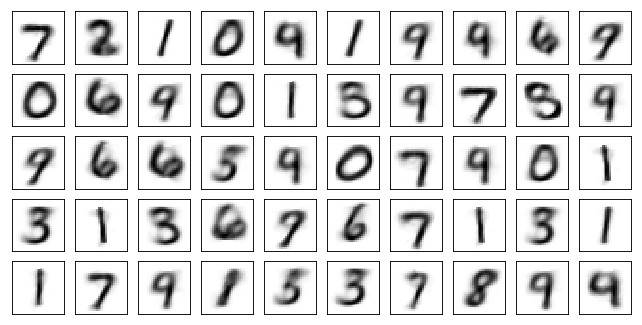

torch.Size([100, 1, 28, 28])


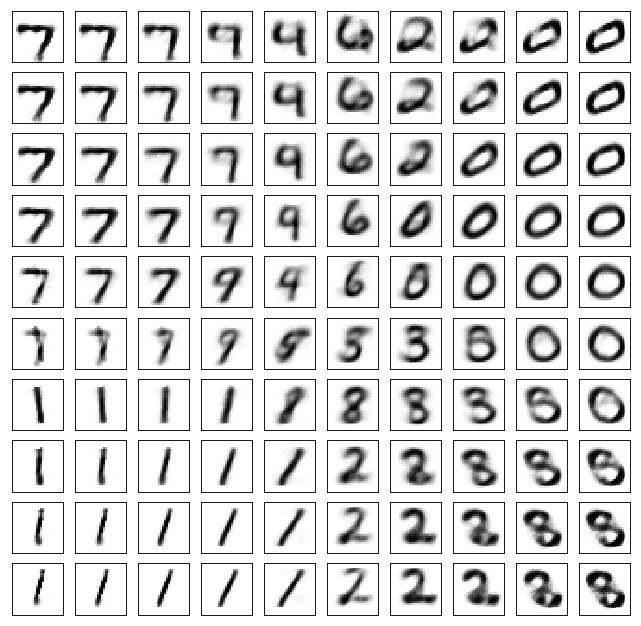

Test losses: VAE10: 0.1600/4.5858
Train Epoch: 19 [0/50000 (0%)]	Losses VAE10: 0.1657
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE10: 0.1568
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE10: 0.1847
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE10: 0.1676
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE10: 0.1701
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE10: 0.1589


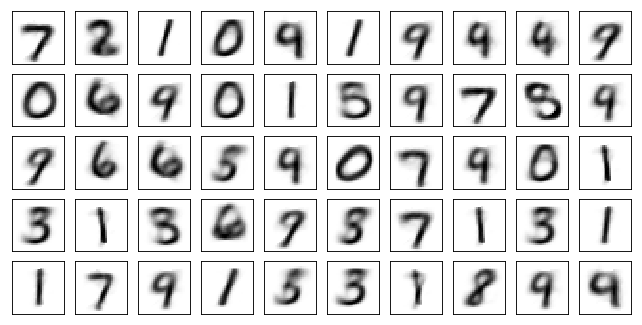

torch.Size([100, 1, 28, 28])


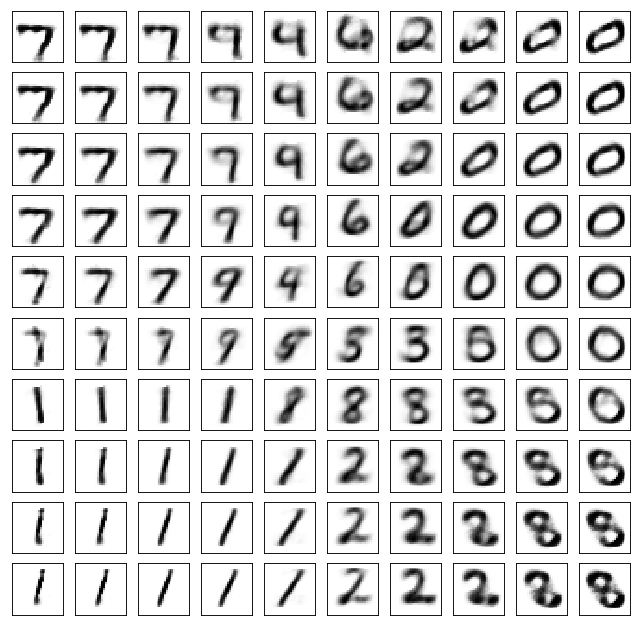

Test losses: VAE10: 0.1597/4.5185
Train Epoch: 20 [0/50000 (0%)]	Losses VAE10: 0.1446
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE10: 0.1643
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE10: 0.1474
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE10: 0.1575
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE10: 0.1711
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE10: 0.1482


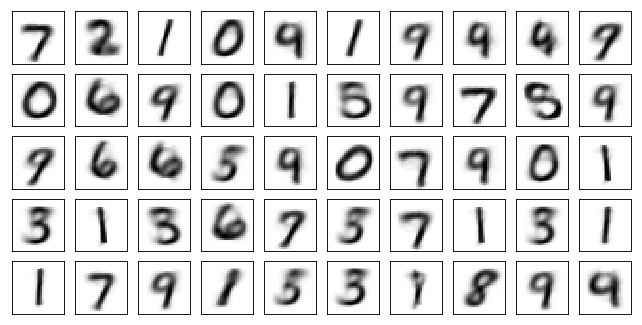

torch.Size([100, 1, 28, 28])


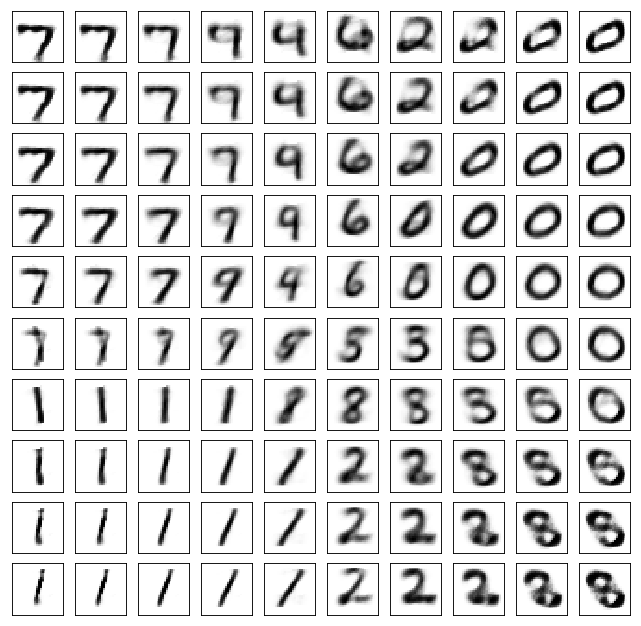

Test losses: VAE10: 0.1589/4.7386
Train Epoch: 21 [0/50000 (0%)]	Losses VAE10: 0.1647
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE10: 0.1606
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE10: 0.1771
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE10: 0.1695
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE10: 0.1615
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE10: 0.1713


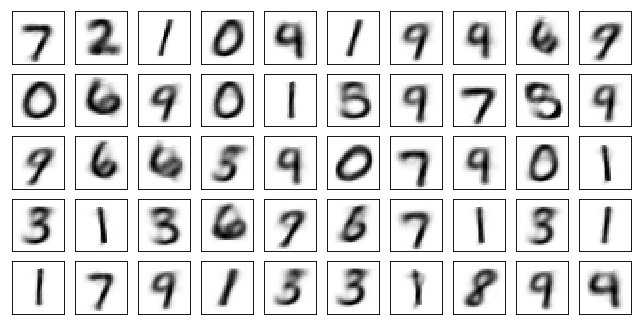

torch.Size([100, 1, 28, 28])


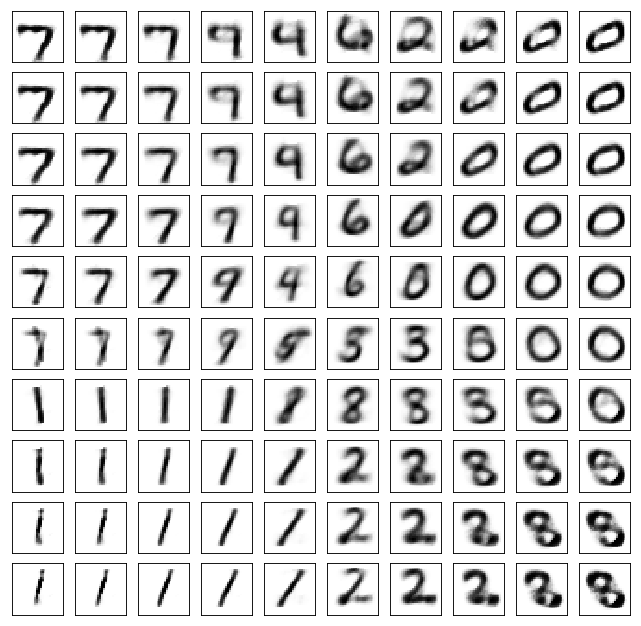

Test losses: VAE10: 0.1580/4.7942
Train Epoch: 22 [0/50000 (0%)]	Losses VAE10: 0.1514
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE10: 0.1676
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE10: 0.1604
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE10: 0.1735
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE10: 0.1458
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE10: 0.1476


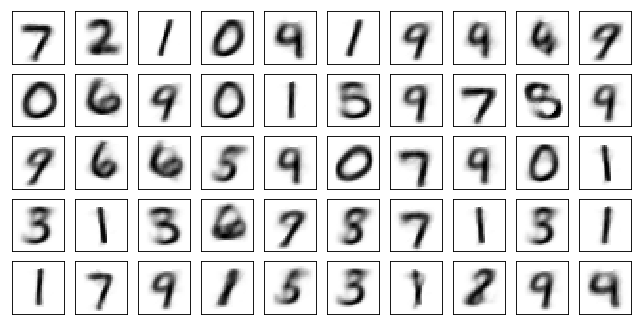

torch.Size([100, 1, 28, 28])


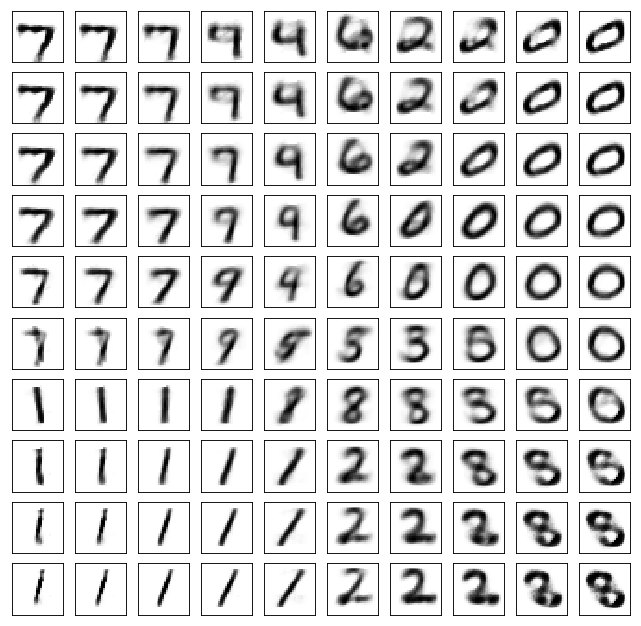

Test losses: VAE10: 0.1579/4.8164
Train Epoch: 23 [0/50000 (0%)]	Losses VAE10: 0.1596
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE10: 0.1529
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE10: 0.1596
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE10: 0.1566
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE10: 0.1536
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE10: 0.1644


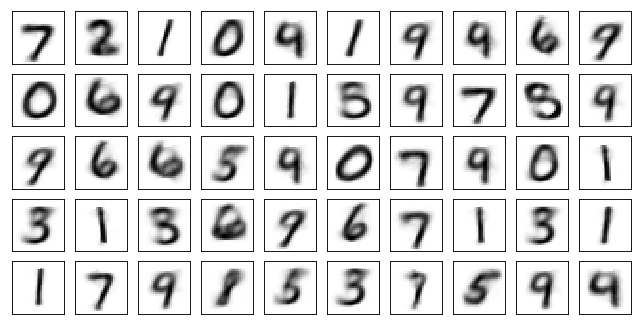

torch.Size([100, 1, 28, 28])


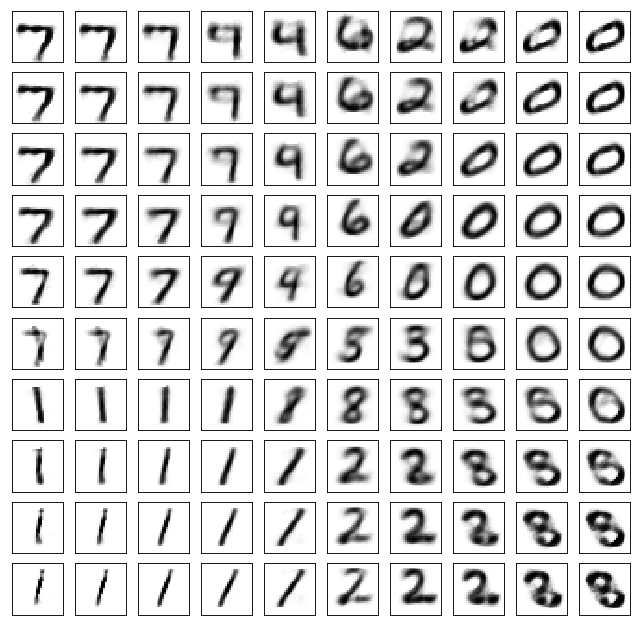

Test losses: VAE10: 0.1570/4.7272
Train Epoch: 24 [0/50000 (0%)]	Losses VAE10: 0.1510
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE10: 0.1543
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE10: 0.1589
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE10: 0.1485
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE10: 0.1603
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE10: 0.1535


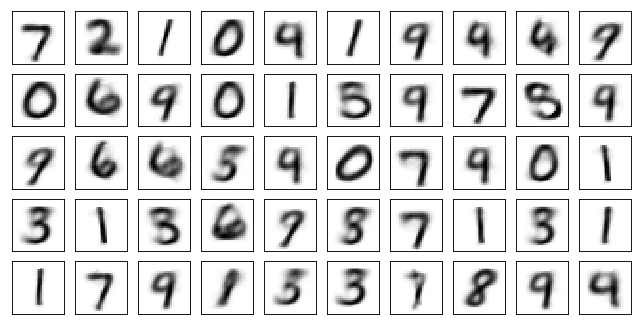

torch.Size([100, 1, 28, 28])


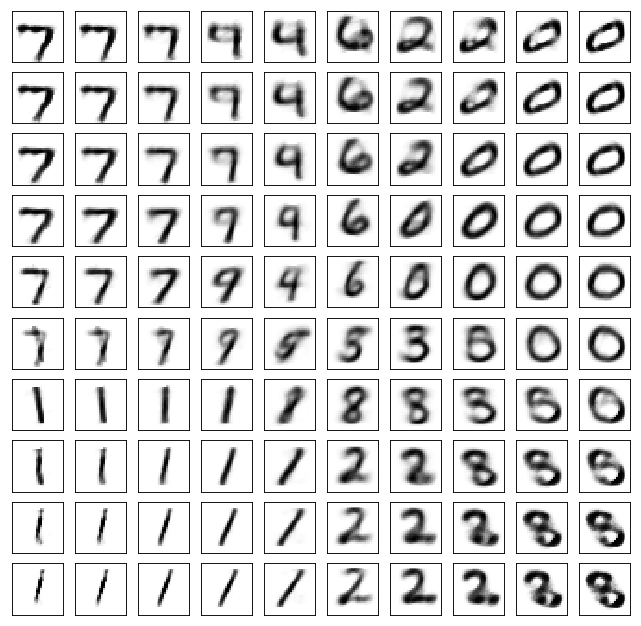

Test losses: VAE10: 0.1565/4.6937
Train Epoch: 25 [0/50000 (0%)]	Losses VAE10: 0.1706
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE10: 0.1553
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE10: 0.1727


In [ ]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [ ]:
len(xy)

In [ ]:
len(xy)